# Эксперименты с временным рядом стоимости алюминия

In [10]:
import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 60)
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#import torch
from darts import TimeSeries
from darts.metrics import mape
from darts.models import AutoARIMA, ExponentialSmoothing, Prophet, LinearRegressionModel
from darts.dataprocessing.transformers import Scaler

from datetime import timedelta
from copy import deepcopy
import random

In [11]:
import optuna
from functools import partial

## Data

In [12]:
FORECAST_LEN = 4 # Длина прогноза
OUT_OF_TIME_DIM = 20 # Размер отложенной выборки

In [13]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    
set_seed()

In [14]:
df = pd.read_csv('prepared_dataset_al.csv', parse_dates=[0], dtype='float32')
print('Shape:', df.shape)

Shape: (282, 67)


In [15]:
df.describe()

,bloomberg_metals_price_mean_4,chalco_adj_std_13,usa_inflation_value_shift_13,usd_to_hkd_increment_by_mean_26,rual_price_std_26,ftse_index_std_13,hongqiao_adj_std_4,alcoa_price_std_4,norsk_hydro_adj_std_4,bloomberg_metals_price_std_9,chalco_price_std_4,eu_inflation_value_increment_by_mean_26,ftse_index_std_4,USD_JPY_rate_increment_by_mean_26,ftse_index_change_mean_52,eu_inflation_value_std_13,rual_price_std_13,baltic_dry_index_std_9,export_australia_value_std_26,australia_pmi_std_26,sp_metals_price_std_4,bloomberg_metals_price_std_4,USD_EUR_rate_std_26,import_usa_value_std_13,export_usa_value_std_9,guinea_inflation_std_26,sp_metals_price_std_9,usa_gdp_increment_value,norsk_hydro_adj_increment_by_mean_26,rual_price_std_4,...,log10_kaiser_volume_std_9,brazil_inflation_std_26,log10_kaiser_volume_std_4,mosexchange_value_std_4,shanghai_index_std_4,import_brazil_value_std_26,import_usa_value_increment_by_mean_26,ftse_index_change_std_13,guinea_inflation_std_13,export_usa_value_std_26,export_usa_value_increment_by_mean_26,USD_EUR_rate_std_13,ftse_index_change_mean_26,export_brazil_value_std_13,sp_metals_change_std_9,rual_price_change_mean_26,export_brazil_value_increment_by_mean_26,rual_price_change_std_26,rual_price_change_std_13,china_pmi2_value_std_13,log10_alcoa_volume_std_13,log10_alcoa_volume_std_9,export_china_value_increment_by_mean_26,covid,after_feb,lme_price_smooth,target_1,target_2,target_3,target_4
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,...,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,2.820000e+02,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,2.820000e+02,282.000000,282.000000,282.000000,281.000000,280.000000,279.000000,278.000000
mean,138.559113,0.319516,0.309423,-0.000843,4.249986,273.543396,0.259927,1.800147,1.449233,4.563441,0.168945,0.227759,139.332413,1.663174,0.111457,0.181089,2.888936,264.172943,38.807678,1.468726,61.469463,2.826630,0.015950,130076.195312,143881.859375,0.477580,95.824181,2.179436,1.091418,1.485700,...,0.181229,0.768479,0.155476,171.235138,54.980236,18.217363,17068.943359,1.026909,0.329527,260680.625000,3.658002e+04,0.010979,0.086928,11.451565,0.859504,0.069141,1.836829,1.367122,1.222799,1.929837,0.131023,0.120998,4.268951e+04,0.228467,0.162726,2187.586670,-0.311324,-0.602007,-0.583585,-0.399618
std,27.089277,0.184627,0.315599,0.019017,2.630195,177.179459,0.196332,1.611941,1.076748,3.385589,0.137156,0.419358,106.679466,4.338950,0.205780,0.113887,2.095899,173.432083,11.945754,0.910203,42.420738,2.543974,0.008652,86156.429688,199285.578125,0.447644,59.999840,3.307303,5.963383,1.465832,...,0.074597,0.416949,0.079136,149.405640,60.812988,7.940274,280205.500000,0.880100,0.404302,222130.921875,3.697457e+05,0.006033,0.254548,7.060465,0.334876,0.259328,17.119184,0.726316,0.823724,2.333842,0.064236,0.058733,3.875421e+05,0.388796,0.300243,440.553650,54.538860,88.763176,113.060982,135.670944
min,92.510361,0.052547,-0.800000,-0.061387,0.997777,54.833698,0.012340,0.180923,0.099812,0.709486,0.013164,-0.456593,17.186796,-9.918187,-0.298297,0.000000,0.633519,32.954060,20.460823,0.315536,1.132393,0.132410,0.004820,13935.265625,4.350456,0.047933,25.982565,-7.500000,-17.344406,0.151132,...,0.062280,0.075746,0.025223,11.993413,3.007912,5.112617,-739684.187500,0.358280,0.000000,34.463089,-1.048385e+06,0.003077,-0.383544,1.025469,0.357106,-0.644664,-45.708199,0.519534,0.443797,0.123188,0.063388,0.044006,-2.087662e+06,0.000000,0.000000,1479.717651,-250.823135,-405.278900,-482.037415,-501.510193
25%,115.814018,0.181782,0.114286,-0.007432,2.388422,157.340839,0.104818,0.797250,0.685221,2.282125

In [32]:
# Извлекаем временной ряд с ценами на медь
data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
# Извлекаем коварианты
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=df.columns.values[1:-5])
# Возьмем срез данных для всего процесса развития модели ts & past_cov и out-of-time выборку
ts = data_ts[:-OUT_OF_TIME_DIM]
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]
# Размер выборки out-of-time = 26 точек (то есть 26 недель = 6 месяцев)
# out-of-time выборка будет использована лишь в самом конце

In [17]:
import datetime

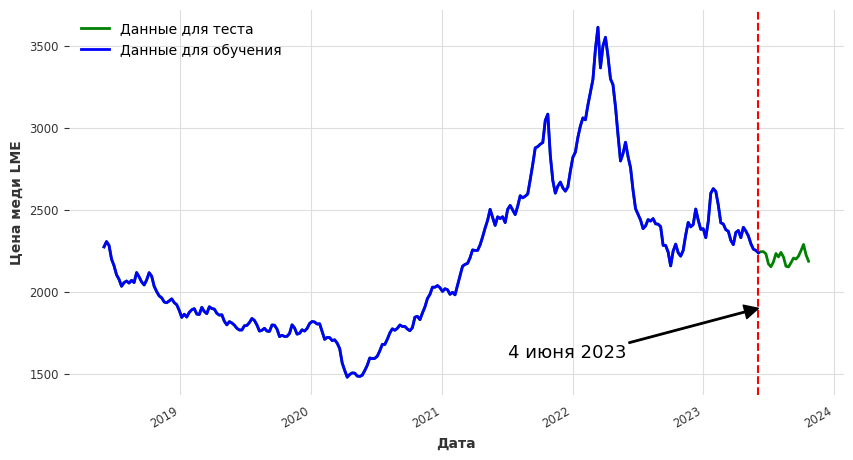

In [18]:
# Рисуем
# Рисуем
fig, ax = plt.subplots(figsize=(10, 5))
data_ts.plot(label="Данные для теста", color='g')
ts.plot(label="Данные для обучения", color='b')
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.annotate('4 июня 2023', xy=(ts.end_time(), 1900), xytext=(ts.end_time() - datetime.timedelta(700), 1600),
            arrowprops=dict(facecolor='black', width=1, headwidth=10, headlength=10), fontsize = 13
            )
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
#plt.savefig('preview.png', dpi=400, format='png')

In [63]:
AutoARIMA?

In [79]:
model = AutoARIMA(start_p=2, d=None, start_q=2, max_p=10, max_d=3, max_q=10, start_P=1, D=None, 
                  start_Q=1, max_P=5, max_D=5, max_Q=5, max_order=10, m=1, seasonal=True, stationary=False, 
                  information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb',
                  stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=5000, 
                  offset_test_args=None, seasonal_test_args=None, suppress_warnings=True,
                  error_action='trace', trace=False, random=False, random_state=None, n_fits=10,
                  out_of_sample_size=0, scoring='mse', with_intercept='auto')
model.fit(ts)
pred = model.predict(20)

In [86]:
mape(data_ts, pred)

1.5438539800320676

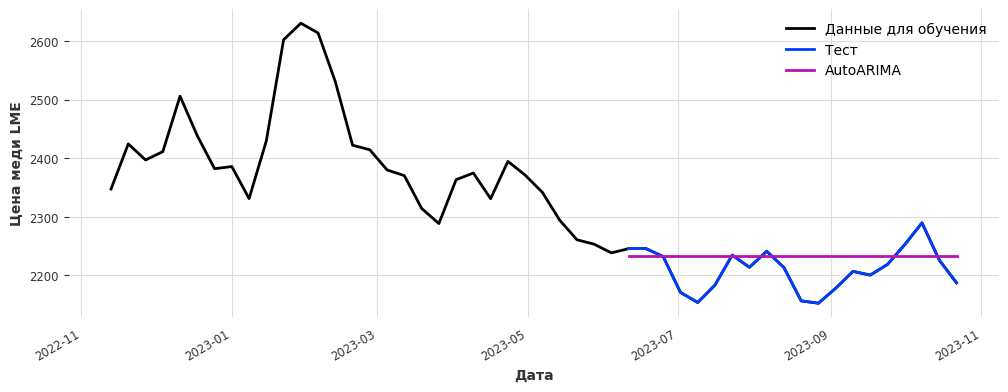

In [88]:
fig, ax = plt.subplots(figsize=(12, 4))
data_ts[-50:].plot(label="Данные для обучения")
data_ts[-OUT_OF_TIME_DIM:].plot(label="Тест")
pred.plot(label="AutoARIMA")
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
plt.savefig('arima.png', dpi=400, format='png')

## Tools

### Cross-validation

In [10]:
# Использовать backtest нет смысла, так как в нем не реализована функция трансформации данных (Scaler)
# Судя по github darts на октябрь 2023 идет разработка данного модуля

# average_error = tcn_model.backtest(
#     series = ts_train,
#     past_covariates=
#     start=0.5,
#     forecast_horizon=17,
#     stride = 9
#     metric=mape,
#     reduction=np.mean,  # this is actually the default
#     retrain = True
#     verbose=True,
# )

# print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

Так как backtest не работает, пропишем ручную версию  
В ручной версии подразумевается обучение модели с нуля на каждом шаге

In [35]:
def manual_backtest(model, ts, past_covariates, forecast_horizont=FORECAST_LEN, 
                    start_test=180, step = 10, save_curves=False,
                    rolling_window=False, window_size=None):
    '''
    Функция аналогична встроенной функции backtest
    '''
    metrics = list() # Список для метрик
    prediction_curves = dict() # Список для последюущей визуализации кривых
    k=1
    # Скользящее или расширяющееся окно
    if rolling_window: 
        start_train = start_test - window_size
    else:
        start_train=0
    while True:
        print('Iter #', k)
        cur_train = ts[start_train : start_test]
        cur_test = ts[start_test : start_test + int(forecast_horizont)]
        # Инициализация scaler-ов
        scaler_ts, scaler_past_cov = Scaler(), Scaler()
        # Есть ли экзогенные признаки
        if past_covariates is not None:
            past_cov_train = past_covariates[start_train : start_test]
            past_cov_test = past_covariates[start_test : start_test + int(forecast_horizont)]
            
            cur_train_scaled = scaler_ts.fit_transform(cur_train)
            past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)
            cur_test_scaled = scaler_ts.transform(cur_test)
            past_cov_test_scaled = scaler_past_cov.transform(past_cov_test)
            
            model1 = deepcopy(model)
            model1.fit(series=cur_train_scaled,
                        past_covariates=past_cov_train_scaled)
            cur_pred_scaled = model1.predict(int(forecast_horizont),
                                             series=cur_train_scaled,
                                             past_covariates=past_cov_train_scaled)
            cur_pred = scaler_ts.inverse_transform(cur_pred_scaled)
        # Если экзогенных признаков нет  
        else:
            cur_train_scaled = scaler_ts.fit_transform(cur_train)
            cur_test_scaled = scaler_ts.transform(cur_test)
            
            model1 = deepcopy(model)
            model1.fit(series=cur_train_scaled)
            cur_pred_scaled = model1.predict(int(forecast_horizont),
                                             series=cur_train_scaled)
            cur_pred = scaler_ts.inverse_transform(cur_pred_scaled)
        # Вычисляем метрику и добавляем в список   
        metric = mape(cur_test, cur_pred, intersect=True)
        metrics.append(metric)
        # n_epochs.append(model1.epochs_trained)
        # При необходимости можно собирать информацию о количестве эпох обучения
        # Добавляем спрогнозированную кривую в набор кривых для последующей отрисовки
        prediction_curves['pred_'+str(k)]=cur_pred
        k+=1
        
        start_test+=step
        if rolling_window:
            start_train+=step
        if start_test + int(forecast_horizont) >= len(ts):
            break
            
    if save_curves==True:
        return metrics, prediction_curves
    else:
        return metrics

### Hyperparameter optimization (optuna)

In [33]:
def objective(trial, ts, past_cov, forecast_len = FORECAST_LEN):
    
    settings = {
        "lags" : trial.suggest_int("lags", 1, 60),
        "lags_past_covariates" : trial.suggest_int("lags_past_covariates", 1, 60)
    }
    settings_for_backtest = {
        "rolling_window" : trial.suggest_categorical("rolling_window", [True, False])
    }
    if settings_for_backtest["rolling_window"] == True:
        settings_for_backtest["window_size"] = trial.suggest_categorical("window_size", [104, 156])
    
    # build and train the model with these hyper-parameters:
    model = LinearRegressionModel(
        **settings,
        output_chunk_length=4,
        random_state=42
    )

    # Evaluate how good it is on the cross_validation for ts
    metrics = manual_backtest(model, ts=ts, past_covariates=past_cov, **settings_for_backtest)
    mean_metric = np.mean(metrics)
    return mean_metric if mean_metric != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}", end='\n\n')
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}", end='\n\n')

def opt(ts, past_cov, iterations):
    opt_function=partial(objective, ts=ts, past_cov=past_cov)
    study = optuna.create_study(direction="minimize")
    study.optimize(opt_function, n_trials=iterations, callbacks=[print_callback])
    print("Number of finished trials: {}".format(len(study.trials)), end='\n\n')
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}", end='\n\n')
    for key, value in study.best_trial.params.items():
        print("  {}: {}".format(key, value))
    return study

### Feature selection

In [42]:
def forward_selection(df, settings, settings_for_backtest, forecast_len = FORECAST_LEN, out_of_time_dim = OUT_OF_TIME_DIM):
    metrics_dict = dict()
    # Извлечем список признаков, важно, что в датасете признаки упорядочены по убыванию уровня корреляции
    all_features = df.drop(columns=['date','lme_price_smooth','target_1','target_2','target_3','target_4']).columns.values.copy()
    candidates = list()
    # Стартовая "лучшая" метрика
    last_min = 1e8
    k=0
    for feature in all_features:
        candidates.append(feature)

        ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
        ts = ts[:-out_of_time_dim]
        past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
        past_cov = past_cov[:-out_of_time_dim]
        
        model = LinearRegressionModel(
            **settings,
            output_chunk_length=4,
            random_state=42
        )
        
        print(candidates)
        
        metrics = manual_backtest(model, ts=ts, past_covariates=past_cov, **settings_for_backtest)
        mean_metric = np.mean(metrics)

        if mean_metric < 0.99*last_min:
            print(candidates)
            print('Metric:', mean_metric)
            print('===============')
            last_min = mean_metric
            k=0
        else:
            print(candidates)
            print('Metric increased:', mean_metric)
            print('===============')
            candidates.pop()
            k+=1
        
        if k>=6:
            break

    print('\n\n')
    print('Feature selection is completed')
    return candidates

In [22]:
def setup_params(best_params):
    if best_params['rolling_window']==True:
        settings_for_backtest = {
            'rolling_window':True,
            'window_size': best_params['window_size']
        }
        del best_params['rolling_window']
        del best_params['window_size']
    else:
        settings_for_backtest = {
            'rolling_window':False
        }
        del best_params['rolling_window']
    return best_params, settings_for_backtest

In [56]:
def evaluation_without_refitting(model_settings, backtest_settings, df, candidates, forecast_len=FORECAST_LEN, out_of_time_dim=OUT_OF_TIME_DIM):
    '''
    Функция для построения прогноза и вычисления метрик на out-of-time выборке
    
    df - датасет временного ряда
    out_of_time_dim - размер выборки out-of-time
    forecast_len - длина прогноза
    '''
    data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
    data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
    
    ts = data_ts[:-out_of_time_dim]
    past_cov = data_past_cov[:-out_of_time_dim]
    
    model = LinearRegressionModel(**model_settings,output_chunk_length=4,random_state=42)

    if backtest_settings["rolling_window"]==True:
        ts_train = ts[- backtest_settings["window_size"] : ]
        past_cov_train = past_cov[- backtest_settings["window_size"] : ]
    else:
        ts_train = ts
        past_cov_train = past_cov
    
    scaler_ts, scaler_past_cov = Scaler(), Scaler()
    ts_train_scaled = scaler_ts.fit_transform(ts_train)
    past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)
    
    model.fit(series=ts_train_scaled,
              past_covariates=past_cov_train_scaled
             )

    start_point = 0
    metrics = list()
    prediction_curves = {}
    step = 1
    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    out_of_time_ts = data_ts[-(out_of_time_dim + shift):]
    out_of_time_past_cov = data_past_cov[-(out_of_time_dim + shift):]
    while True:
        cur_test_input = out_of_time_ts[start_point : start_point + shift]
        past_cov_test_input = out_of_time_past_cov[start_point : start_point + shift]
        cur_test_input_scaled = scaler_ts.transform(cur_test_input)
        past_cov_test_input_scaled = scaler_past_cov.transform(past_cov_test_input)
        prediction_scaled = model.predict(int(forecast_len), series=cur_test_input_scaled, past_covariates=past_cov_test_input_scaled)
        prediction = scaler_ts.inverse_transform(prediction_scaled)
        metric = mape(prediction, out_of_time_ts)
        metrics.append(metric)
        start_point+=step
        prediction_curves[start_point]=prediction
        if start_point + shift + int(forecast_len) > len(out_of_time_ts):
            break

    print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
    return prediction_curves, metrics

# def evaluation_with_refitting(model_settings, backtest_settings, df, candidates, forecast_len=FORECAST_LEN, out_of_time_dim=OUT_OF_TIME_DIM):

#     data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
#     data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
    
#     model = RandomForest(
#         **model_settings,
#         output_chunk_length=forecast_len,
#         n_jobs=16,
#         random_state=42
#         )
    
#     shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    
#     threshold = 0
#     metrics = list()
#     prediction_curves = {}
#     step = 1
#     shift = max(model_settings["lags"], model_settings["lags_past_covariates"])
#     out_of_time_ts = data_ts[-(out_of_time_dim + shift):]
#     out_of_time_past_cov = data_past_cov[-(out_of_time_dim + shift):]
#     while True:
#         if threshold%3==0:
#             ts = data_ts[:-out_of_time_dim]
#             past_cov = data_past_cov[:-out_of_time_dim]

#             if backtest_settings["rolling_window"]==True:
#                 ts_train = ts[- backtest_settings["window_size"] : ]
#                 past_cov_train = past_cov[- backtest_settings["window_size"] : ]
#             else:
#                 ts_train = ts
#                 past_cov_train = past_cov

#             scaler_ts, scaler_past_cov = Scaler(), Scaler()
#             ts_train_scaled = scaler_ts.fit_transform(ts_train)
#             past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)

#             model.fit(series=ts_train_scaled,
#                       past_covariates=past_cov_train_scaled
#                      )
#             cur_test_input = out_of_time_ts[threshold : threshold + shift]
#             past_cov_test_input = out_of_time_past_cov[threshold : threshold + shift]
#             cur_test_input_scaled = scaler_ts.transform(cur_test_input)
#             past_cov_test_input_scaled = scaler_past_cov.transform(past_cov_test_input)
#             prediction_scaled = model.predict(int(forecast_len), series=cur_test_input, past_covariates=past_cov_test_input)
#             prediction = scaler_ts.inverse_transform(prediction_scaled) 
#             metric = mape(prediction, out_of_time_ts)
#             metrics.append(metric)
#             threshold+=step
#             prediction_curves[threshold]=prediction
#             if threshold + shift + int(forecast_len) > len(out_of_time_ts):
#                 break
#         else:
#             cur_test_input = out_of_time_ts[threshold : threshold + shift]
#             past_cov_test_input = out_of_time_past_cov[threshold : threshold + shift]
#             cur_test_input_scaled = scaler_ts.transform(cur_test_input)
#             past_cov_test_input_scaled = scaler_past_cov.transform(past_cov_test_input)
#             prediction_scaled = model.predict(int(forecast_len), series=cur_test_input, past_covariates=past_cov_test_input)
#             prediction = scaler_ts.inverse_transform(prediction_scaled)
#             metric = mape(prediction, out_of_time_ts)
#             metrics.append(metric)
#             threshold+=step
#             prediction_curves[threshold]=prediction
#             if threshold + shift + int(forecast_len) > len(out_of_time_ts):
#                 break

#     print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
#     return prediction_curves, metrics

def train_metric_evaluation(model_settings, backtest_settings, df, out_of_time_dim=OUT_OF_TIME_DIM, forecast_len=FORECAST_LEN, candidates=None):
    '''
    Функция для вычисления метрики на train выборке
    df - датасет всех данных
    model - модель
    out_of_time-dim - размер выборки out-of-time
    forecast_len - длина прогноза
    scaler_ts, scaler_past_cov - скейлеры
    '''
    data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
    data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
    
    ts = data_ts[:-out_of_time_dim]
    past_cov = data_past_cov[:-out_of_time_dim]
    
    model = LinearRegressionModel(**model_settings,output_chunk_length=4,random_state=42)

    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    if backtest_settings["rolling_window"]==True:
        ts_train = ts[- backtest_settings["window_size"] : ]
        past_cov_train = past_cov[- backtest_settings["window_size"] : ]
    else:
        ts_train = ts
        past_cov_train = past_cov
    
    scaler_ts, scaler_past_cov = Scaler(), Scaler()
    ts_train_scaled = scaler_ts.fit_transform(ts_train)
    past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)
    
    model.fit(series=ts_train_scaled,
              past_covariates=past_cov_train_scaled
             )
    
    start_point = 0
    metrics = list()
    step = 5
    while True:
        cur_test_input = ts[start_point : start_point + shift]
        past_cov_test_input = past_cov[start_point : start_point + shift]
        cur_test_input_scaled = scaler_ts.transform(cur_test_input)
        past_cov_test_input_scaled = scaler_past_cov.transform(past_cov_test_input)

        prediction_scaled = model.predict(series=cur_test_input_scaled,
                                          past_covariates=past_cov_test_input_scaled,
                                          n=int(forecast_len))
        prediction = scaler_ts.inverse_transform(prediction_scaled)

        metric = mape(prediction, ts)
        metrics.append(metric)
        start_point+=step
        if start_point + shift + int(forecast_len) > len(ts):
            break
                
    print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
    return metrics

## Build models

### Hyperparameter optimization with all features

In [36]:
study = opt(ts=ts, past_cov=past_cov, iterations=10)

[I 2024-01-14 02:59:54,930] A new study created in memory with name: no-name-887c956b-1a32-4b01-933a-03f50c429e7f


Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:00:06,425] Trial 0 finished with value: 6.502221897244453 and parameters: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 6.502221897244453.


Current value: 6.502221897244453, Current params: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}

Best value: 6.502221897244453, Best params: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:00:13,507] Trial 1 finished with value: 6.945124268531799 and parameters: {'lags': 35, 'lags_past_covariates': 35, 'rolling_window': True, 'window_size': 104}. Best is trial 0 with value: 6.502221897244453.


Current value: 6.945124268531799, Current params: {'lags': 35, 'lags_past_covariates': 35, 'rolling_window': True, 'window_size': 104}

Best value: 6.502221897244453, Best params: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:00:16,884] Trial 2 finished with value: 8.113775728270411 and parameters: {'lags': 55, 'lags_past_covariates': 13, 'rolling_window': True, 'window_size': 104}. Best is trial 0 with value: 6.502221897244453.


Current value: 8.113775728270411, Current params: {'lags': 55, 'lags_past_covariates': 13, 'rolling_window': True, 'window_size': 104}

Best value: 6.502221897244453, Best params: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:00:21,950] Trial 3 finished with value: 7.272068690508604 and parameters: {'lags': 10, 'lags_past_covariates': 45, 'rolling_window': True, 'window_size': 104}. Best is trial 0 with value: 6.502221897244453.


Current value: 7.272068690508604, Current params: {'lags': 10, 'lags_past_covariates': 45, 'rolling_window': True, 'window_size': 104}

Best value: 6.502221897244453, Best params: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:00:37,684] Trial 4 finished with value: 6.838617939502001 and parameters: {'lags': 13, 'lags_past_covariates': 20, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 6.502221897244453.


Current value: 6.838617939502001, Current params: {'lags': 13, 'lags_past_covariates': 20, 'rolling_window': True, 'window_size': 156}

Best value: 6.502221897244453, Best params: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:01:05,090] Trial 5 finished with value: 8.584445528686047 and parameters: {'lags': 17, 'lags_past_covariates': 13, 'rolling_window': False}. Best is trial 0 with value: 6.502221897244453.


Current value: 8.584445528686047, Current params: {'lags': 17, 'lags_past_covariates': 13, 'rolling_window': False}

Best value: 6.502221897244453, Best params: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:01:12,254] Trial 6 finished with value: 7.87719446234405 and parameters: {'lags': 32, 'lags_past_covariates': 23, 'rolling_window': True, 'window_size': 104}. Best is trial 0 with value: 6.502221897244453.


Current value: 7.87719446234405, Current params: {'lags': 32, 'lags_past_covariates': 23, 'rolling_window': True, 'window_size': 104}

Best value: 6.502221897244453, Best params: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:01:33,699] Trial 7 finished with value: 6.768105528317392 and parameters: {'lags': 35, 'lags_past_covariates': 19, 'rolling_window': False}. Best is trial 0 with value: 6.502221897244453.


Current value: 6.768105528317392, Current params: {'lags': 35, 'lags_past_covariates': 19, 'rolling_window': False}

Best value: 6.502221897244453, Best params: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:01:45,692] Trial 8 finished with value: 6.983456341549754 and parameters: {'lags': 41, 'lags_past_covariates': 24, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 6.502221897244453.


Current value: 6.983456341549754, Current params: {'lags': 41, 'lags_past_covariates': 24, 'rolling_window': True, 'window_size': 156}

Best value: 6.502221897244453, Best params: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:01:54,117] Trial 9 finished with value: 7.889455417171121 and parameters: {'lags': 19, 'lags_past_covariates': 26, 'rolling_window': True, 'window_size': 104}. Best is trial 0 with value: 6.502221897244453.


Current value: 7.889455417171121, Current params: {'lags': 19, 'lags_past_covariates': 26, 'rolling_window': True, 'window_size': 104}

Best value: 6.502221897244453, Best params: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}

Number of finished trials: 10

Best value: 6.502221897244453, Best params: {'lags': 52, 'lags_past_covariates': 34, 'rolling_window': True, 'window_size': 156}

  lags: 52
  lags_past_covariates: 34
  rolling_window: True
  window_size: 156


In [37]:
best_settings = study.best_trial.params
best_params, settings_for_backtest = setup_params(best_settings)

In [38]:
best_params

{'lags': 52, 'lags_past_covariates': 34}

In [39]:
settings_for_backtest

{'rolling_window': True, 'window_size': 156}

In [43]:
# feature selection
candidates = forward_selection(df, settings=best_params, settings_for_backtest=settings_for_backtest)

['bloomberg_metals_price_mean_4']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
['bloomberg_metals_price_mean_4']
Metric: 35.143105406314135
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13']
Metric: 23.50490167737007
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13']
Metric: 17.175949551165104
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13', 'usd_to_hkd_increment_by_mean_26']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13', 'usd_to_hkd_increment_by_mean_26']
Metric: 13.6640555690974
['bloomberg

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13', 'usd_to_hkd_increment_by_mean_26', 'rual_price_std_26', 'hongqiao_adj_std_4', 'alcoa_price_std_4', 'bloomberg_metals_price_std_9', 'chalco_price_std_4', 'eu_inflation_value_increment_by_mean_26', 'ftse_index_change_mean_52', 'eu_inflation_value_std_13', 'rual_price_std_13']
Metric increased: 6.151536526158452
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13', 'usd_to_hkd_increment_by_mean_26', 'rual_price_std_26', 'hongqiao_adj_std_4', 'alcoa_price_std_4', 'bloomberg_metals_price_std_9', 'chalco_price_std_4', 'eu_inflation_value_increment_by_mean_26', 'ftse_index_change_mean_52', 'eu_inflation_value_std_13', 'baltic_dry_index_std_9']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13', 'usa_inflation_value_shift_13', 'usd_to_hkd_i

In [44]:
candidates

['bloomberg_metals_price_mean_4',
 'chalco_adj_std_13',
 'usa_inflation_value_shift_13',
 'usd_to_hkd_increment_by_mean_26',
 'rual_price_std_26',
 'hongqiao_adj_std_4',
 'alcoa_price_std_4',
 'bloomberg_metals_price_std_9',
 'chalco_price_std_4',
 'eu_inflation_value_increment_by_mean_26',
 'ftse_index_change_mean_52',
 'eu_inflation_value_std_13',
 'australia_pmi_std_26']

### Repeat hyperparameter optimization with selected features

In [45]:
candidates = ['bloomberg_metals_price_mean_4',
 'chalco_adj_std_13',
 'usa_inflation_value_shift_13',
 'usd_to_hkd_increment_by_mean_26',
 'rual_price_std_26',
 'hongqiao_adj_std_4',
 'alcoa_price_std_4',
 'bloomberg_metals_price_std_9',
 'chalco_price_std_4',
 'eu_inflation_value_increment_by_mean_26',
 'ftse_index_change_mean_52',
 'eu_inflation_value_std_13',
 'australia_pmi_std_26']
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]

In [46]:
# перед запуском поменял сетку параметров на более детальную
study_1 = opt(ts=ts, past_cov=past_cov, iterations=20)

[I 2024-01-14 03:04:30,548] A new study created in memory with name: no-name-6bd710b1-5bc3-4b78-a1a6-ae92c6af8280


Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:04:37,572] Trial 0 finished with value: 5.843358533456922 and parameters: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 5.843358533456922.


Iter # 8
Current value: 5.843358533456922, Current params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:04:38,080] Trial 1 finished with value: 6.873455666936934 and parameters: {'lags': 47, 'lags_past_covariates': 1, 'rolling_window': False}. Best is trial 0 with value: 5.843358533456922.


Iter # 8
Current value: 6.873455666936934, Current params: {'lags': 47, 'lags_past_covariates': 1, 'rolling_window': False}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:04:43,314] Trial 2 finished with value: 6.186023773625493 and parameters: {'lags': 55, 'lags_past_covariates': 27, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.186023773625493, Current params: {'lags': 55, 'lags_past_covariates': 27, 'rolling_window': True, 'window_size': 156}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:04:48,709] Trial 3 finished with value: 7.430336158722639 and parameters: {'lags': 29, 'lags_past_covariates': 18, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 5.843358533456922.


Current value: 7.430336158722639, Current params: {'lags': 29, 'lags_past_covariates': 18, 'rolling_window': True, 'window_size': 156}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:01,706] Trial 4 finished with value: 6.4935395726934075 and parameters: {'lags': 35, 'lags_past_covariates': 59, 'rolling_window': False}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.4935395726934075, Current params: {'lags': 35, 'lags_past_covariates': 59, 'rolling_window': False}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:05:03,660] Trial 5 finished with value: 10.267750034108758 and parameters: {'lags': 48, 'lags_past_covariates': 10, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 5.843358533456922.


Iter # 8
Current value: 10.267750034108758, Current params: {'lags': 48, 'lags_past_covariates': 10, 'rolling_window': True, 'window_size': 156}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:17,039] Trial 6 finished with value: 6.39064353890717 and parameters: {'lags': 59, 'lags_past_covariates': 29, 'rolling_window': False}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.39064353890717, Current params: {'lags': 59, 'lags_past_covariates': 29, 'rolling_window': False}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7


[I 2024-01-14 03:05:19,707] Trial 7 finished with value: 6.9312430918216705 and parameters: {'lags': 7, 'lags_past_covariates': 58, 'rolling_window': True, 'window_size': 104}. Best is trial 0 with value: 5.843358533456922.


Iter # 8
Current value: 6.9312430918216705, Current params: {'lags': 7, 'lags_past_covariates': 58, 'rolling_window': True, 'window_size': 104}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:32,090] Trial 8 finished with value: 6.515130959451199 and parameters: {'lags': 11, 'lags_past_covariates': 51, 'rolling_window': False}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.515130959451199, Current params: {'lags': 11, 'lags_past_covariates': 51, 'rolling_window': False}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:35,084] Trial 9 finished with value: 6.727613601833582 and parameters: {'lags': 26, 'lags_past_covariates': 43, 'rolling_window': True, 'window_size': 104}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.727613601833582, Current params: {'lags': 26, 'lags_past_covariates': 43, 'rolling_window': True, 'window_size': 104}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:41,686] Trial 10 finished with value: 6.317301467061043 and parameters: {'lags': 39, 'lags_past_covariates': 40, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.317301467061043, Current params: {'lags': 39, 'lags_past_covariates': 40, 'rolling_window': True, 'window_size': 156}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:48,061] Trial 11 finished with value: 6.160688539966941 and parameters: {'lags': 59, 'lags_past_covariates': 28, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 5.843358533456922.


Current value: 6.160688539966941, Current params: {'lags': 59, 'lags_past_covariates': 28, 'rolling_window': True, 'window_size': 156}

Best value: 5.843358533456922, Best params: {'lags': 52, 'lags_past_covariates': 36, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:05:56,310] Trial 12 finished with value: 5.819835560396314 and parameters: {'lags': 49, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}. Best is trial 12 with value: 5.819835560396314.


Current value: 5.819835560396314, Current params: {'lags': 49, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Best value: 5.819835560396314, Best params: {'lags': 49, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:04,710] Trial 13 finished with value: 5.802537780255079 and parameters: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 5.802537780255079.


Current value: 5.802537780255079, Current params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:13,054] Trial 14 finished with value: 6.355118146166205 and parameters: {'lags': 42, 'lags_past_covariates': 47, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 5.802537780255079.


Current value: 6.355118146166205, Current params: {'lags': 42, 'lags_past_covariates': 47, 'rolling_window': True, 'window_size': 156}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:16,852] Trial 15 finished with value: 6.685559311881661 and parameters: {'lags': 20, 'lags_past_covariates': 37, 'rolling_window': True, 'window_size': 104}. Best is trial 13 with value: 5.802537780255079.


Current value: 6.685559311881661, Current params: {'lags': 20, 'lags_past_covariates': 37, 'rolling_window': True, 'window_size': 104}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:25,146] Trial 16 finished with value: 5.911545013077557 and parameters: {'lags': 41, 'lags_past_covariates': 22, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 5.802537780255079.


Current value: 5.911545013077557, Current params: {'lags': 41, 'lags_past_covariates': 22, 'rolling_window': True, 'window_size': 156}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:34,664] Trial 17 finished with value: 6.323117623105645 and parameters: {'lags': 46, 'lags_past_covariates': 51, 'rolling_window': True, 'window_size': 156}. Best is trial 13 with value: 5.802537780255079.


Current value: 6.323117623105645, Current params: {'lags': 46, 'lags_past_covariates': 51, 'rolling_window': True, 'window_size': 156}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:45,742] Trial 18 finished with value: 5.899570928886533 and parameters: {'lags': 34, 'lags_past_covariates': 35, 'rolling_window': False}. Best is trial 13 with value: 5.802537780255079.


Current value: 5.899570928886533, Current params: {'lags': 34, 'lags_past_covariates': 35, 'rolling_window': False}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


[I 2024-01-14 03:06:48,366] Trial 19 finished with value: 7.056488003581762 and parameters: {'lags': 23, 'lags_past_covariates': 45, 'rolling_window': True, 'window_size': 104}. Best is trial 13 with value: 5.802537780255079.


Current value: 7.056488003581762, Current params: {'lags': 23, 'lags_past_covariates': 45, 'rolling_window': True, 'window_size': 104}

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

Number of finished trials: 20

Best value: 5.802537780255079, Best params: {'lags': 45, 'lags_past_covariates': 39, 'rolling_window': True, 'window_size': 156}

  lags: 45
  lags_past_covariates: 39
  rolling_window: True
  window_size: 156


In [47]:
best_settings_1 = study_1.best_trial.params
new_best_params, new_settings_for_backtest = setup_params(best_settings_1)

In [48]:
new_best_params

{'lags': 45, 'lags_past_covariates': 39}

In [49]:
new_settings_for_backtest

{'rolling_window': True, 'window_size': 156}

### Backtest with refit on each step

In [51]:
linear_model = LinearRegressionModel(**new_best_params,output_chunk_length=4,random_state=42)
bt_metrics, pred_ts = manual_backtest(model=linear_model, ts=ts, past_covariates=past_cov,
                                   save_curves=True, **new_settings_for_backtest)

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8


In [52]:
np.mean(bt_metrics), np.std(bt_metrics)

(5.802537780255079, 1.7348082227557957)

In [53]:
print("Backtest MAPE: {:.2f} +- {:.2f}".format(np.mean(bt_metrics), np.std(bt_metrics)))

Backtest MAPE: 5.80 +- 1.73


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

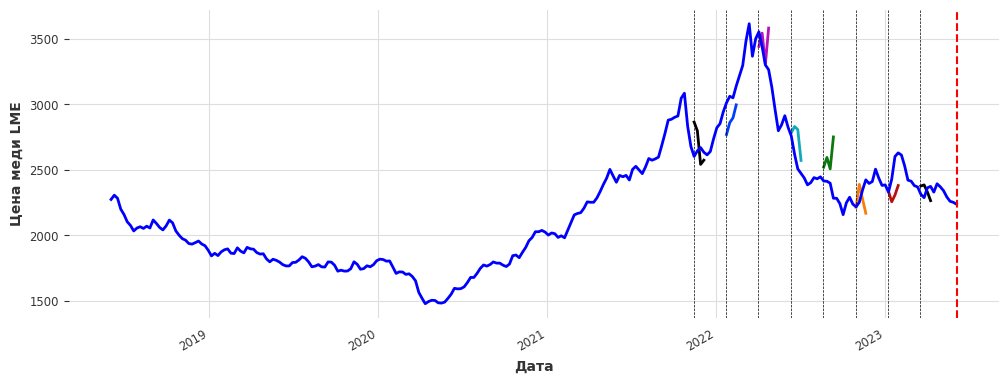

In [55]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in pred_ts.items():
    value.plot(label=None);
    ax.axvline(x=value.start_time() - datetime.timedelta(1), color='black', linestyle='--', linewidth=0.5)
ts.plot(color='blue', label=None)
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
plt.savefig('pic3.png', dpi=400, format='png')

Text(0.5, 0, 'Number of historical forecast')

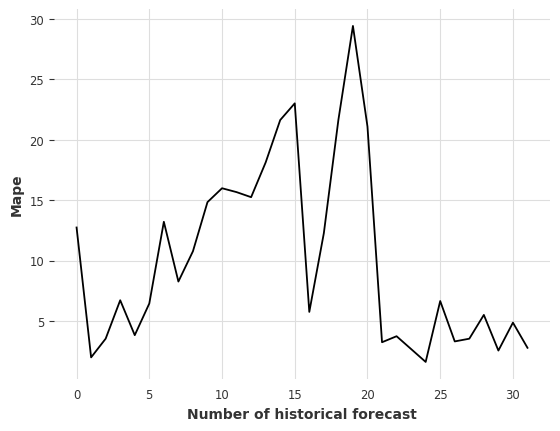

In [59]:
fig, ax = plt.subplots()
ax = sns.lineplot(bt_metrics)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of historical forecast')

### Fit and evaluate without refitting

In [57]:
candidates = ['bloomberg_metals_price_mean_4',
 'chalco_adj_std_13',
 'usa_inflation_value_shift_13',
 'usd_to_hkd_increment_by_mean_26',
 'rual_price_std_26',
 'hongqiao_adj_std_4',
 'alcoa_price_std_4',
 'bloomberg_metals_price_std_9',
 'chalco_price_std_4',
 'eu_inflation_value_increment_by_mean_26',
 'ftse_index_change_mean_52',
 'eu_inflation_value_std_13',
 'australia_pmi_std_26']

prediction_curves, out_of_time_metrics_no_refit = evaluation_without_refitting(model_settings=new_best_params,
                                                                               backtest_settings=new_settings_for_backtest,
                                                                               df=df,
                                                                               candidates=candidates
                                                                              )

MAPE: 5.09 +- 2.48


In [58]:
print("Out-of-time MAPE without refit: {:.2f} +- {:.2f}".format(np.mean(out_of_time_metrics_no_refit), np.std(out_of_time_metrics_no_refit)))

Out-of-time MAPE without refit: 5.09 +- 2.48


Text(0.5, 0, 'Number of prediction on the out-of-time set')

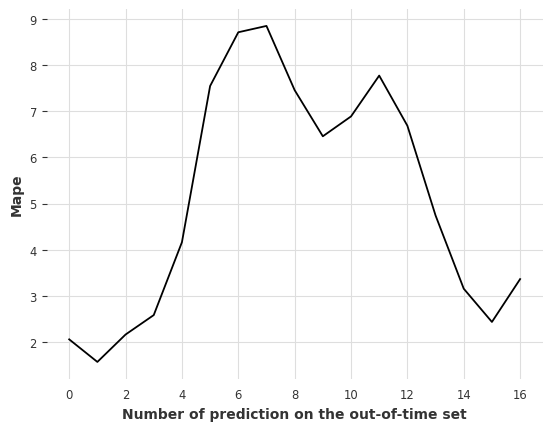

In [59]:
fig, ax = plt.subplots()
ax = sns.lineplot(out_of_time_metrics_no_refit)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of prediction on the out-of-time set')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

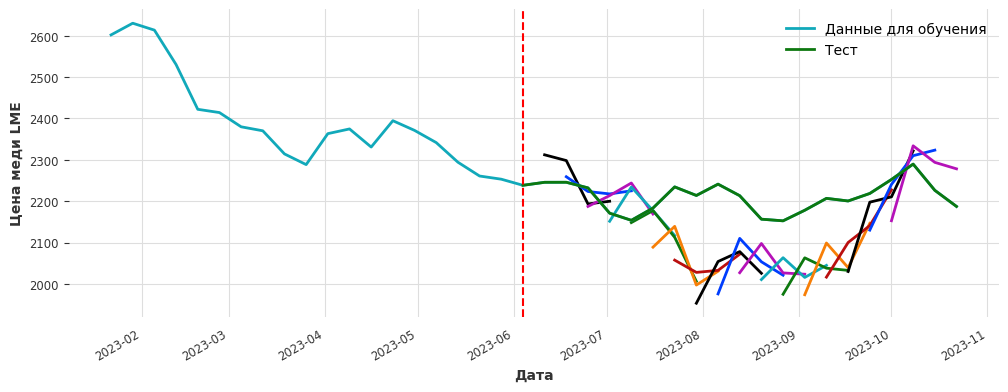

In [62]:


fig, ax = plt.subplots(figsize=(12, 4))
for key, value in prediction_curves.items():
    value.plot(label=None)
data_ts[-2*OUT_OF_TIME_DIM:].plot(label='Данные для обучения')
data_ts[-OUT_OF_TIME_DIM-1:].plot(label='Тест')
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
plt.savefig('pic3.png', dpi=400, format='png')

### Fit and evaluate with refitting

In [81]:
candidates = ['bloomberg_metals_price_mean_4',
              'ftse_index_change_mean_52',
              'USD_EUR_rate_std_26',
              'usa_gdp_increment_value',
              'rual_price_std_4',
              'australia_inflation_increment_by_mean_26',
              'australia_inflation_std_26',
              'australia_pmi_std_13']

prediction_curves, out_of_time_metrics_refit = evaluation_with_refitting(model_settings=new_best_params,
                                                                            backtest_settings=new_settings_for_backtest,
                                                                            df=df,
                                                                            candidates=candidates
                                                                           )

MAPE: 21.54 +- 1.44


In [83]:
print("Out-of-time MAPE without refit: {:.2f} +- {:.2f}".format(np.mean(out_of_time_metrics_refit), np.std(out_of_time_metrics_refit)))

Out-of-time MAPE without refit: 21.54 +- 1.44


Text(0.5, 0, 'Number of prediction on the out-of-time set')

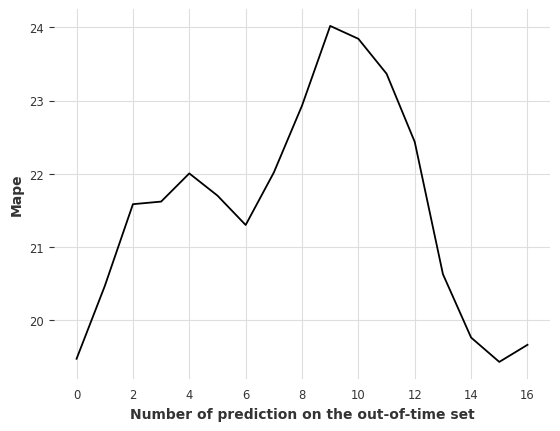

In [85]:
fig, ax = plt.subplots()
ax = sns.lineplot(out_of_time_metrics_refit)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of prediction on the out-of-time set')

<Axes: xlabel='date'>

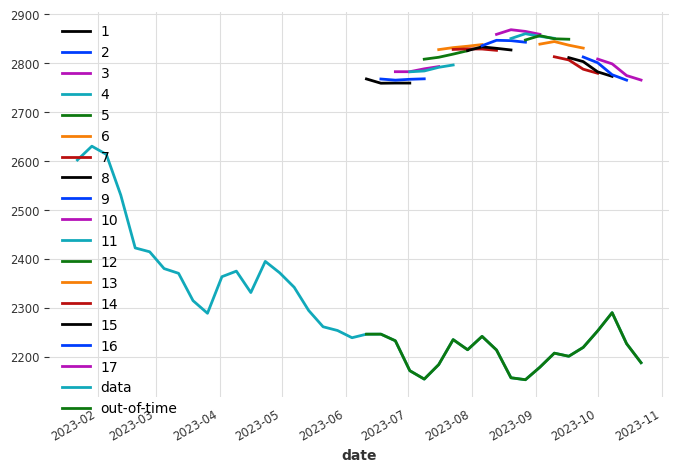

In [86]:
plt.figure(figsize=(8,5))
for key, value in prediction_curves.items():
    value.plot(label=key)
data_ts[-2*OUT_OF_TIME_DIM:].plot(label='data')
data_ts[-OUT_OF_TIME_DIM:].plot(label='out-of-time')

### Evaluate train metrics without refitting

In [64]:
candidates = ['bloomberg_metals_price_mean_4',
 'chalco_adj_std_13',
 'usa_inflation_value_shift_13',
 'usd_to_hkd_increment_by_mean_26',
 'rual_price_std_26',
 'hongqiao_adj_std_4',
 'alcoa_price_std_4',
 'bloomberg_metals_price_std_9',
 'chalco_price_std_4',
 'eu_inflation_value_increment_by_mean_26',
 'ftse_index_change_mean_52',
 'eu_inflation_value_std_13',
 'australia_pmi_std_26']

In [65]:
train_metrics = train_metric_evaluation(model_settings=new_best_params,
                                        backtest_settings=new_settings_for_backtest,
                                        df=df,
                                        candidates=candidates)

MAPE: 11.75 +- 12.71


In [66]:
np.mean(train_metrics), np.std(train_metrics)

(11.74593188026683, 12.708235260414336)

Text(0.5, 0, 'Number of prediction on the out-of-time set')

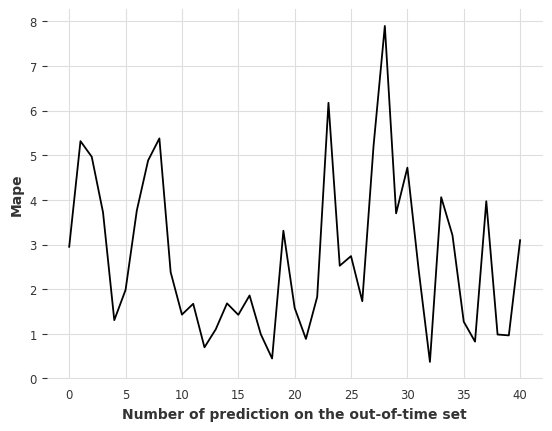

In [92]:
fig, ax = plt.subplots()
ax = sns.lineplot(train_metrics)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of prediction on the out-of-time set')

In [96]:
metrics_dict = {
    "train_mean_mape":np.mean(train_metrics),
    "train_std_mape":np.std(train_metrics),
    "backtest_mean_mape":np.mean(bt_metrics),
    "backtest_std_mape":np.std(bt_metrics),
    "test_mean_mape_no_reffit":np.mean(out_of_time_metrics_no_refit),
    "test_std_mape_no_reffit":np.std(out_of_time_metrics_no_refit),
    "test_mean_mape_reffit":np.mean(out_of_time_metrics_refit),
    "test_std_mape_reffit":np.std(out_of_time_metrics_refit),
}
params = new_best_params | new_settings_for_backtest

In [97]:
metrics_dict

{'train_mean_mape': 2.7176062773993332,
 'train_std_mape': 1.7625621857696292,
 'backtest_mean_mape': 10.085882897643685,
 'backtest_std_mape': 7.49027008124043,
 'test_mean_mape_no_reffit': 7.206361656816628,
 'test_std_mape_no_reffit': 1.1254847389027458,
 'test_mean_mape_reffit': 21.543207929010645,
 'test_std_mape_reffit': 1.4447026421019704}

In [98]:
params

{'lags': 4,
 'lags_past_covariates': 58,
 'n_estimators': 100,
 'max_depth': 11,
 'min_samples_split': 2,
 'max_features': 'log2',
 'max_samples': 0.2,
 'rolling_window': False}